In [26]:
!jupyter nbconvert --to markdown 8_6_7_Exercises.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook 8_6_7_Exercises.ipynb to markdown
[NbConvertApp] Writing 12051 bytes to 8_6_7_Exercises.md


In [4]:
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

class Alexnet(d2l.Classifier):
    def __init__(self,lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
                                 nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
                                 nn.LazyConv2d(256, kernel_size=5, padding=2),
                                 nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
                                 nn.LazyConv2d(384, kernel_size=3, padding=1),nn.ReLU(),
                                 nn.LazyConv2d(384, kernel_size=3, padding=1),nn.ReLU(),
                                 nn.LazyConv2d(256, kernel_size=3, padding=1),nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
                                 nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
                                 nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
                                 nn.LazyLinear(num_classes)
                                 )

# 1. Following up on the discussion above, analyze the computational properties of AlexNet.



## 1.1 Compute the memory footprint for convolutions and fully connected layers, respectively. Which one dominates?



Fomula of the number of parameters of convolutions is $\sum^{layers}(c_i*c_o*k_h*k_w+c_o)$

In [14]:
3*96*11*11+96+96*256*5*5+256+256*384*3*3+384+384*384*3*3+384+384*256*3*3+256

3747200

Fomula of the number of parameters of fully connected is $\sum^{layers}(x_i*x_o+x_o)$

In [46]:
80*80*4096+4096+4096*4096+4096+4096*10+10

43040778

The **fully connected layers** dominates

In [8]:
model = Alexnet()
X = torch.randn(1,3, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) not in (nn.Linear,nn.Conv2d):
        continue
    num = sum(p.numel() for p in module.parameters())
    # print(f"Module {idx + 1}: {num} parameters type:{type(module)}")
    if type(module) == nn.Conv2d:
        params['conv'] += num
       
    else:
        params['lr'] += num

params

{'conv': 3747200, 'lr': 43040778}

In [12]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
         MaxPool2d-3           [-1, 96, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]         614,656
              ReLU-5          [-1, 256, 26, 26]               0
         MaxPool2d-6          [-1, 256, 12, 12]               0
            Conv2d-7          [-1, 384, 12, 12]         885,120
              ReLU-8          [-1, 384, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]       1,327,488
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         884,992
             ReLU-12          [-1, 256, 12, 12]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
          Flatten-14                 [-

## 1.2 Calculate the computational cost for the convolutions and the fully connected layers.

Fomula of the computational cost for convolutions is $\sum^{layers}(c_i*c_o*k_h*k_w*h_o*w_o)$

In [61]:
3*96*11*11*54*54+96*256*5*5*26*26+256*384*3*3*12*12+384*384*3*3*12*12+384*256*3*3*12*12

962858112

Fomula of the computational cost for fully connected layers is $\sum^{layers}(x_i*x_o+x_o)$

In [65]:
80*80*4096+4096+4096*4096+4096+4096*10+10

43040778

In [67]:
x = torch.randn(1,3, 224, 224)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    c_i = x.shape[1]
    x = module(x)
    if type(module) == nn.Conv2d:
        k = [p.shape for p in module.parameters()]
        c_o,h_o,w_o = x.shape[1], x.shape[2], x.shape[3]
        params['conv'] += c_i*c_o*h_o*w_o*k[0][-1]*k[0][-2]
    if type(module) == nn.Linear:
        params['lr'] += sum(p.numel() for p in module.parameters())
params

{'conv': 962858112, 'lr': 43040778}

In [22]:
X = torch.randn(1,3, 224, 224)
_ = model(X)
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Total parameters: 46787978


## 1.3 How does the memory (read and write bandwidth, latency, size) affect computation? Is there any difference in its effects for training and inference?

Memory characteristics, including read and write bandwidth, latency, and size, have a significant impact on computation in both training and inference of neural networks. These factors can influence the overall performance, efficiency, and speed of the computation. Here's how these memory aspects affect computation and any potential differences between training and inference:

**Read and Write Bandwidth**:
- **Effect**: High read and write bandwidth enables faster data movement between memory and processing units. It allows for efficient data retrieval and storage during computations.
- **Impact**: Faster data access improves the throughput of computations, reducing the time spent waiting for data to arrive. It can lead to faster training and inference times.
- **Training vs. Inference**: Both training and inference benefit from high bandwidth, as data movement is a common bottleneck in both phases.

**Latency**:
- **Effect**: Latency is the time taken to access data from memory. Lower latency results in quicker data access and faster computations.
- **Impact**: Low-latency memory access reduces the time spent waiting for data to be available for computations, leading to improved processing speed.
- **Training vs. Inference**: Latency affects both training and inference. In training, frequent weight updates and gradient computations require low-latency access to data. In inference, quick responses are crucial for real-time applications.

**Memory Size**:
- **Effect**: Memory size determines how much data can be stored. Larger memory allows for more data to be cached, reducing the need for frequent data movement.
- **Impact**: Sufficient memory size enables efficient caching of data and reduces the need for frequent memory access. It can lead to better performance by avoiding memory bottlenecks.
- **Training vs. Inference**: Both training and inference benefit from having enough memory to hold intermediate results and data. In training, large memory can accommodate gradients, activations, and model parameters. In inference, it allows for storing intermediate results during feedforward passes.

**Training and Inference Differences**:
- In training, memory bandwidth is often crucial due to the frequent updates of weights and gradients during backpropagation. Batch processing amplifies memory bandwidth requirements.
- In inference, low latency and high memory bandwidth are important for real-time applications, but the focus might shift slightly towards optimizing for latency and response time.

**Memory Hierarchy**:
- Modern architectures often have different memory levels with varying characteristics (e.g., cache, GPU memory, main memory). Optimizing data placement and movement across these levels is crucial for performance.
- Memory hierarchy can impact both training and inference by affecting how efficiently data is accessed and utilized.

In summary, memory characteristics significantly influence neural network computation. High bandwidth, low latency, sufficient memory size, and efficient memory hierarchy are all essential for achieving optimal performance in both training and inference. While there might be nuances in how these aspects affect training and inference, addressing memory-related bottlenecks is crucial for overall efficiency and speed in deep learning computations.

# 2. You are a chip designer and need to trade off computation and memory bandwidth. For example, a faster chip requires more power and possibly a larger chip area. More memory bandwidth requires more pins and control logic, thus also more area. How do you optimize?



Optimizing the trade-off between computation and memory bandwidth in chip design is a complex task that involves careful consideration of various factors. The goal is to achieve a balance between computation speed, memory access efficiency, power consumption, chip size, and other performance metrics. Here's a step-by-step approach to optimizing this trade-off:

1. **Define Performance Goals**:
   - Understand the specific requirements of the target application (e.g., real-time inference, batch training, energy efficiency) and define performance goals in terms of computation speed, memory access speed, and overall system efficiency.

2. **Profile Workloads**:
   - Analyze the workload characteristics of the application. Identify the key computational tasks, memory access patterns, data sizes, and communication frequencies between computation and memory.

3. **Architectural Exploration**:
   - Explore different architectural options to determine the optimal balance between computation units (cores, SIMD units, accelerators) and memory subsystems (cache hierarchy, memory banks).
   - Consider trade-offs such as the number of cores, cache size, cache associativity, and memory hierarchy.

4. **Memory Hierarchy Design**:
   - Design memory hierarchies that provide efficient data access and minimize memory bottlenecks.
   - Decide on cache levels, cache coherence protocols, memory types (SRAM, DRAM), and interconnect architectures.

5. **Power Efficiency**:
   - Optimize power consumption by considering techniques like dynamic voltage and frequency scaling (DVFS), clock gating, power gating, and energy-efficient memory access policies.

6. **Chip Area and Integration**:
   - Balance the chip area between computation and memory components based on performance requirements, available space, and cost constraints.
   - Consider integrating memory close to computational units to reduce memory latency and improve memory bandwidth.

7. **Memory Bandwidth Enhancement**:
   - Explore techniques to enhance memory bandwidth, such as wide memory buses, high-speed memory interfaces (e.g., HBM, GDDR), and efficient memory controller designs.

8. **Parallelism and Pipelining**:
   - Incorporate parallelism and pipelining techniques to overlap computation and memory access, reducing the impact of memory latency on overall performance.

9. **Simulation and Modeling**:
   - Use simulation and modeling tools to evaluate different design choices and configurations.
   - Analyze performance metrics, power consumption, and other relevant parameters for different scenarios.

10. **Feedback Loop**:
   - Iteratively refine the design by gathering feedback from simulations, prototypes, and benchmarks.
   - Fine-tune the trade-offs based on the observed trade-offs between computation and memory bandwidth.

11. **Validation and Testing**:
   - Validate the optimized design through thorough testing and validation across various workloads and usage scenarios.

12. **Real-World Constraints**:
   - Consider real-world constraints such as manufacturing process technology, cost limitations, and time-to-market.

Ultimately, the optimization process involves a careful consideration of performance, power, area, and cost factors. Collaboration among chip architects, designers, and domain experts is essential to make informed decisions and strike the right balance between computation and memory bandwidth.

# 3. Why do engineers no longer report performance benchmarks on AlexNet?



1. **Aging Benchmark**: AlexNet, while pioneering, was introduced in 2012, and its architecture might not represent the state-of-the-art in terms of efficiency and accuracy compared to more recent models. Newer models, architectures, and techniques have been developed that surpass the performance of AlexNet on various tasks.

2. **Advancements in Architecture**: Over the years, more advanced architectures like VGG, ResNet, Inception, and Transformer-based models (BERT, GPT, etc.) have been developed and have become more popular for benchmarking and research. These architectures often achieve better accuracy and efficiency than AlexNet.

3. **Domain-Specific Models**: Depending on the application domain, engineers might prefer to benchmark models that are tailored to specific tasks. For instance, models like EfficientNet for efficient image classification or object detection networks like Faster R-CNN might be more relevant and commonly used for specific tasks.

4. **Diverse Benchmarks**: With the increase in complexity and diversity of tasks, researchers often benchmark models across a wide range of datasets and tasks. This ensures that the performance of a model is tested across various scenarios rather than just focusing on a single benchmark.

5. **Focus on Real-World Applications**: Engineers are increasingly interested in benchmarking models that demonstrate their performance in real-world applications, such as medical image analysis, autonomous driving, natural language understanding, and more. This shift in focus might result in a move away from using AlexNet.

6. **Evolving Hardware and Software**: Performance benchmarks are often influenced by the underlying hardware (GPUs, TPUs) and software (deep learning frameworks, optimizations). As hardware and software landscapes evolve, engineers tend to benchmark newer models that are optimized for the latest hardware and software technologies.

7. **Research Direction**: The field of deep learning research has expanded, and engineers are exploring various directions such as model interpretability, robustness, fairness, and more. These aspects might take precedence over revisiting older models like AlexNet for benchmarking.

It's important to note that the above points are based on trends and developments up until September 2021. The field of deep learning is rapidly evolving, and practices may have changed since then. If you're looking for the most up-to-date information on performance benchmarks and research trends, I recommend checking recent conference proceedings, research papers, and benchmarks provided by organizations in the field.

# 4. Try increasing the number of epochs when training AlexNet. Compared with LeNet, how do the results differ? Why?




KeyboardInterrupt



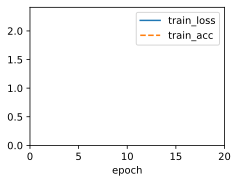

In [2]:
model = Alexnet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224),num_workers=0)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

# 5. AlexNet may be too complex for the Fashion-MNIST dataset, in particular due to the low resolution of the initial images.



## 5.1 Try simplifying the model to make the training faster, while ensuring that the accuracy does not drop significantly.


## 5.2 Design a better model that works directly on $28\times28$ images.



In [ ]:
class SmallAlexnet(d2l.Classifier):
    def __init__(self,lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(256, kernel_size=3, padding=1),nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1),nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(512, kernel_size=3, padding=1),nn.ReLU(),
            nn.LazyConv2d(512, kernel_size=3, padding=1),nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(1024), nn.ReLU(),
            nn.LazyLinear(num_classes)
            )

# 6. Modify the batch size, and observe the changes in throughput (images/s), accuracy, and GPU memory.



# 7. Apply dropout and ReLU to LeNet-5. Does it improve? Can you improve things further by preprocessing to take advantage of the invariances inherent in the images?

In [ ]:
class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyConv2d(6, kernel_size=5, padding=2),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2, stride=2),
                                 nn.LazyConv2d(16, kernel_size=5),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2, stride=2),
                                 nn.Flatten(),
                                 nn.LazyLinear(120),
                                 nn.ReLU(), nn.Dropout(0.5),
                                 nn.LazyLinear(84),
                                 nn.ReLU(), nn.Dropout(0.5),
                                 nn.LazyLinear(num_classes))
model = LeNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(28, 28))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
X,y = next(iter(data.get_dataloader(False)))
X = X.to('cuda')
y = y.to('cuda')
y_hat = model(X)
print(f'acc: {model.accuracy(y_hat,y).item():.2f}')

# 8. Can you make AlexNet overfit? Which feature do you need to remove or change to break training?

Yes, it is possible to intentionally make AlexNet overfit by manipulating certain features of the training process. Overfitting occurs when a model learns to perform exceptionally well on the training data but fails to generalize to unseen data. To make AlexNet overfit, you can modify or manipulate the following features:

1. **Limited Training Data**:
   Reduce the size of the training dataset significantly. With a small training dataset, the model can easily memorize the data, leading to overfitting. For example, if you have 10 classes, consider training with just a handful of images for each class.

2. **Complex Model**:
   Increase the model's capacity by adding more layers, units, or filters. This can lead to the model having more parameters than necessary to fit the small training data, resulting in overfitting.

3. **Reduce Regularization**:
   Decrease or entirely remove regularization techniques such as dropout, weight decay, and data augmentation. Regularization helps prevent overfitting by adding noise or constraints to the training process.

4. **Lower Learning Rate**:
   Use a very small learning rate during training. A small learning rate can cause the model to update its weights very slowly, leading to overfitting as the model doesn't generalize well.

5. **Fewer Epochs**:
   Train the model for a limited number of epochs. Overfitting can occur when the model hasn't had sufficient time to learn meaningful patterns in the data.

6. **Noise-Free Labels**:
   Provide perfectly clean and noise-free labels in the training dataset. In real-world scenarios, there are often label errors or ambiguity, which can actually help prevent overfitting.

7. **Lack of Augmentation**:
   Avoid data augmentation techniques like random rotations, flips, and cropping. Data augmentation introduces variability and helps the model generalize better.

8. **Use Complex Optimizers**:
   Opt for complex optimizers like Adam with default settings, which can lead to quicker convergence on the training data but might also cause overfitting.

By combining these changes, you can create a scenario in which AlexNet overfits the training data. Keep in mind that this exercise is done for demonstration purposes and to understand the behavior of models under different conditions. In practice, overfitting is undesirable, and the goal is to achieve a model that generalizes well to unseen data. Regularization techniques, appropriate dataset splitting, and hyperparameter tuning are used to avoid overfitting and build models with strong generalization performance.